# Notebook for transformer model

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_funcs import load_split_data
from sentence_transformers import SentenceTransformer

In [2]:
# setup PyTorch backend
import os
os.environ['KERAS_BACKEND'] = 'torch'
import torch
print("Using PyTorch backend")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using PyTorch backend
Using device: cuda


In [ ]:
# generate data splits
X_train, X_val, X_test, y_train, y_val, y_test = load_split_data("../data/Sentiment_Analysis.csv")

## Sequence embeddings

In [4]:
# embedding model
emb_model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# pad sequences
import nltk
nltk.download("punkt_tab")
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

def process_text_sequences(max_length=40, padding='post', truncating='post'):
    """
    Convert texts to padded sequences of tokens.

    Args:
        max_length: Maximum sequence length (default: 40)
        padding: 'pre' or 'post' padding (default: 'post')
        truncating: 'pre' or 'post' truncation (default: 'post')

    Returns:
        X_train_padded: Padded training sequences
        X_val_padded: Padded validation sequences
        X_test_padded: Padded test sequences
    """
    data = [X_train, X_val, X_test]
    padded_sequences = []

    for texts in data:
        # Tokenize all texts
        sequences = [word_tokenize(text) for text in texts]

        # Convert tokens to numpy arrays with padding
        padded_sequences.append(pad_sequences(
            sequences=[s[:max_length] for s in sequences],  # Truncate if needed
            maxlen=max_length,
            padding=padding,
            truncating=truncating,
            dtype=object,  # Use object dtype for string tokens
            value=''  # Use empty string as padding token
        ))

    return tuple(padded_sequences)

X_train_padded, X_val_padded, X_test_padded = process_text_sequences()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
from functools import cache
@cache
def encode_words(model, text):
    return model.encode(text)

In [7]:
# convert padded sequences to embeddings
def create_embedding_sequences(model, max_length=40):
    """
    Convert sequences of words to sequences of embeddings using cached word vectors.
    Ensures all sequences have the same length through padding.

    Args:
        model: SentenceTransformer model
        max_length: Maximum sequence length (default: 40)
    Returns:
        X_train_embedded: Training embeddings
        X_val_embedded: Validation embeddings
        X_test_embedded: Test embeddings
    """
    data = [X_train_padded, X_val_padded, X_test_padded]
    embeddings = []
    embedding_dim = model.get_sentence_embedding_dimension()

    for sequences in data:
        n_sequences = len(sequences)

        # Initialize the output array with zeros
        embedded_seqs = np.zeros((n_sequences, max_length, embedding_dim))

        for i, seq in enumerate(sequences):
            # Get embeddings for non-empty tokens
            valid_tokens = [word for word in seq if word != '']
            # Truncate if necessary
            valid_tokens = valid_tokens[:max_length]
            # Create embeddings for valid tokens
            seq_embeddings = [encode_words(model, word) for word in valid_tokens]

            # Add embeddings to the output array with padding
            for j, embedding in enumerate(seq_embeddings):
                if j < max_length:
                    embedded_seqs[i, j] = embedding
        embeddings.append(embedded_seqs)
        print(f"Shape: {embedded_seqs.shape}")

    return tuple(embeddings)

In [8]:
%%time
# generate sequence embeddings
X_train_embedded, X_val_embedded, X_test_embedded = create_embedding_sequences(emb_model)

Shape: (24000, 40, 384)
Shape: (8000, 40, 384)
Shape: (8000, 40, 384)
CPU times: user 5min 11s, sys: 1.41 s, total: 5min 12s
Wall time: 5min 12s


## Transformer model

In [9]:
# Import required layers for transformer
from keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Input, GlobalAveragePooling1D, Add, Dense
from keras.models import Model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self attention with residual connection
    attention_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=head_size,
        dropout=dropout
    )(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = Add()([inputs, attention_output])  # Residual connection
    x1 = LayerNormalization(epsilon=1e-6)(attention_output)

    # Feed-forward network with residual connection
    ffn_output = Dense(ff_dim, activation="relu")(x1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    x2 = Add()([x1, ffn_output])  # Residual connection
    return LayerNormalization(epsilon=1e-6)(x2)

# Build the transformer model
def build_transformer_model(
    max_seq_length=40,
    embed_dim=384,
    num_heads=4,  # Reduced from 8 to better match embedding dimension
    ff_dim=512,   # Increased feed-forward dimension
    num_transformer_blocks=2,
    mlp_units=[256, 128],  # Increased MLP units
    dropout=0.1,
    mlp_dropout=0.1,
):
    inputs = Input(shape=(max_seq_length, embed_dim))
    x = inputs

    # Add positional encoding if needed (not required if using pre-trained embeddings)
    # x = positional_encoding(x)

    # Transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, embed_dim // num_heads, num_heads, ff_dim, dropout)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # MLP layers with residual connections
    for dim in mlp_units:
        x_residual = x
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
        if x_residual.shape[-1] == dim:  # Only add if dimensions match
            x = Add()([x, x_residual])
        x = LayerNormalization(epsilon=1e-6)(x)

    # Classification layer
    outputs = Dense(13, activation="softmax")(x)

    return Model(inputs, outputs)

# Create and compile the model
print("Building transformer model...")
transformer_model = build_transformer_model(
    max_seq_length=40,
    embed_dim=384,
    num_heads=4,      # Adjusted to work better with embedding dimension
    ff_dim=512,       # Increased feed-forward dimension
    num_transformer_blocks=2,
    mlp_units=[256, 128],  # Increased MLP units
    dropout=0.1,
    mlp_dropout=0.1,
)

Building transformer model...


In [10]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Compile the model
transformer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Model summary
transformer_model.summary()

# Add early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model with early stopping
print("\nTraining Transformer model...")
history = transformer_model.fit(
    X_train_embedded,  # Use embedded sequences
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_embedded, y_val),  # Use embedded validation sequences
    callbacks=[early_stopping],
    verbose=1
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 40, 384)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 384)   │    591,360 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40, 384)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 384)   │          0 │ input_layer[0][0… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 40, 384)   │        768 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 40, 512)   │    197,120 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 40, 384)   │    196,992 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 40, 384)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 40, 384)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 384)   │        768 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 384)   │    591,360 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 40, 384)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 40, 384)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 384)   │        768 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 40, 512)   │    197,120 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 40, 384)   │    196,992 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 40, 384)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 40, 384)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 384)   │        768 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,107,917 (8.04 MB)

 Trainable params: 2,107,917 (8.04 MB)

 Non-trainable params: 0 (0.00 B)


Training Transformer model...
Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.2131 - loss: 2.2494 - val_accuracy: 0.2724 - val_loss: 2.0495
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2660 - loss: 2.0579 - val_accuracy: 0.3319 - val_loss: 1.9942
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3118 - loss: 1.9995 - val_accuracy: 0.3405 - val_loss: 1.9504
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3201 - loss: 1.9891 - val_accuracy: 0.3300 - val_loss: 1.9582
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3261 - loss: 1.9515 - val_accuracy: 0.3417 - val_loss: 1.9398
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3251 - loss: 1.9642 - val_accuracy: 0.3449 - val_loss: 1.9438
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3392 - loss: 1.9484 - val_accuracy: 0.3355 - val_loss: 1.9665
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 

## Plots

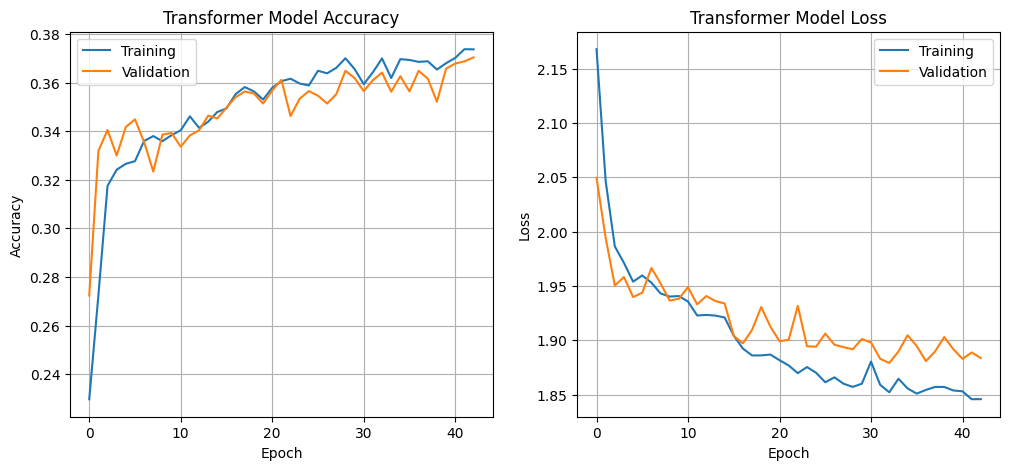

In [11]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Transformer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Transformer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy = transformer_model.evaluate(X_test_embedded, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Evaluating on test set...
Test Loss: 1.8787
Test Accuracy: 0.3595


## Takeaways

- Despite a much greater complexity, the transformer model performs similarly to the baseline MLP and XGBoost models with validation accuracy around **36%** and loss around **1.85**
- There is slight overfitting to the training data in the later epochs